In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
from scipy.interpolate import PchipInterpolator
from typing_extensions import dataclass_transform

For this project I am going to try to make a model that can **predict peoples happiness scores (on a scale of 1-10) based off their income**.

In [4]:
#loading in my data as "data"
data = pd.read_csv('https://raw.githubusercontent.com/rithisenthil/DSF_Submission_Files/refs/heads/main/U5ProjData.csv')

In [ ]:
data

,income,happy_score
0,2097,4.350
1,1449,4.033
2,7101,6.574
3,19457,7.200
4,19917,7.284
...,...,...
106,7544,6.485
107,2231,5.360
108,3889,4.642
109,957,5.129


Text(0, 0.5, 'happy score')

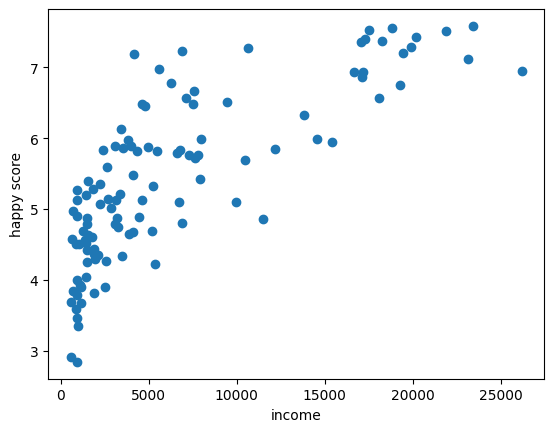

In [5]:
# plot the data into a scater plot

plt.scatter(data['income'] , data['happy_score'],)

plt.xlabel("income")
plt.ylabel("happy score")

A couple major things that I am noticing about this data:

- It looks like a exponential/log function shape
- More than half the points are concentrated in the lower half

keeping these things in mind I continued...

**Version 1**

I decided to start with a very simple model (normal likelhood, no crazy modifications to the lines, etc.) and build from there. However, I made one major mistake. Not realizing what alpha and beta represented, I proceeded to make the y-intercept and slope of my model WAY too strong.

In [ ]:
with pm.Model() as model_v1:

    α = pm.Normal("α", sigma=20000)  #y-int
    β = pm.Normal("β", sigma=15000)  #slope

    #mean line
    μ = pm.Deterministic("μ", α + β * data.income)

    #prior for standard deviation
    σ = pm.HalfNormal("σ", sigma = 5000)

    #normal likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=data.happy_score)

    idata_v1 = pm.sample()

Text(0, 0.5, 'happy score')

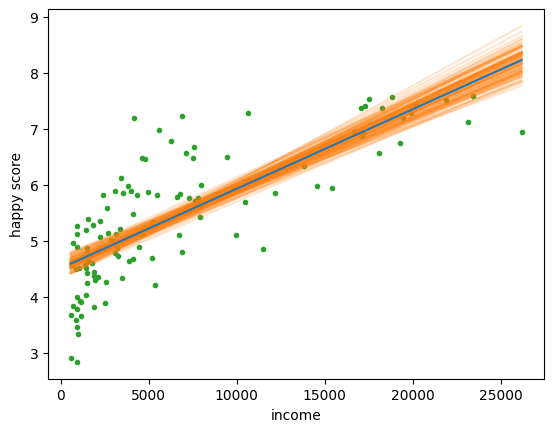

In [ ]:
#posterior predictive graph

#grabs 100 posterior samples
posterior = az.extract(idata_v1, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(data.income.min(), data.income.max(), 50),
    dims="plot_id"
    )


mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

#These are a 50 lines that our model came up with
lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(data.income, data.happy_score, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("income")
ax.set_ylabel("happy score")

Output()

<Axes: xlabel='y_pred'>

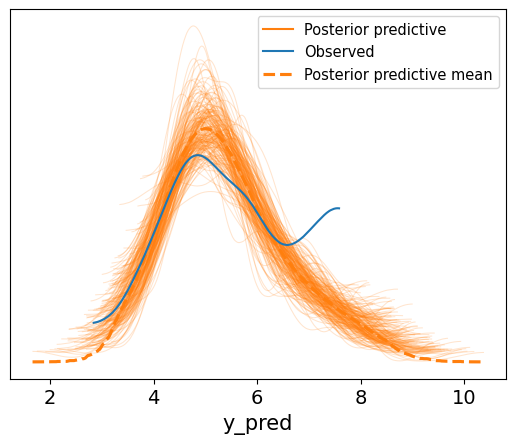

In [ ]:
# posterior predictive check

pm.sample_posterior_predictive(
    idata_v1, model = model_v1, extend_inferencedata=True
    )
az.plot_ppc(idata_v1, num_pp_samples=200, colors=["C1", "C0",hu6   "C1"])

Reflecting on this PPC I am not too suprised. This is more or less whhat I expected, a basic normal distribution that is a pretty bad fit.

**Version 2**

For this version I made 2 major changes:

- Majorly adjusting my prior values
- Square rooting my mean line so that it would better fit the curve of my data

Other than that I kept everything else the same (liklehood and prior distributions)

In [ ]:
with pm.Model() as model_v2:

    α = pm.Normal("α", mu=3, sigma=.5)  #y-int
    β = pm.Normal("β", mu=3, sigma=50)  #slope

    #mean line
    μ = pm.Deterministic("μ", np.sqrt(α + β * data.income))

    #prior for standard deviation
    σ = pm.HalfNormal("σ", sigma = 500)

    #normal likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=data.happy_score)

    idata_v2 = pm.sample()

Output()

Output()

Text(0, 0.5, 'happy score')

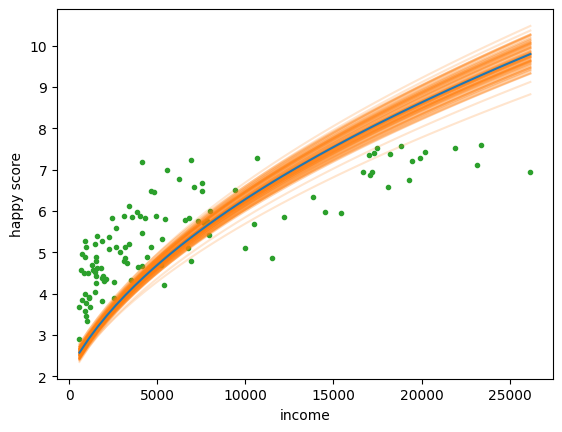

In [ ]:
# posterior predictive graph

#grabs 100 posterior samples
posterior = az.extract(idata_v2, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(data.income.min(), data.income.max(), 50),
    dims="plot_id"
    )


mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

#These are a 50 lines that our model came up with
lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, np.sqrt(lines.T), c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, np.sqrt(mean_line), c="C0", label="mean line")

#plot the raw data
ax.plot(data.income, data.happy_score, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("income")
ax.set_ylabel("happy score")

Output()

(0.0, 10.0)

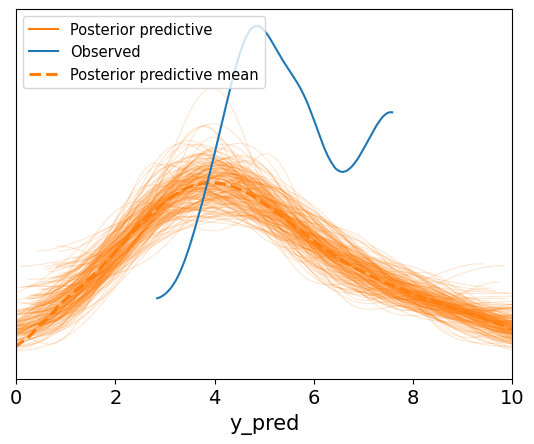

In [ ]:
# posterior predictive check

pm.sample_posterior_predictive(
    idata_v2, model = model_v2, extend_inferencedata=True
    )
ax = az.plot_ppc(idata_v2, num_pp_samples=200, colors=["C1", "C0", "C1"])
plt.xlim(0,10)

Reflecting on this model I see an improvement in my scatter plot (the line is bending more into the shape of my data), but that is overshadowed by the downright abysmal fit of my PPC. But that's ok, I have another idea!

**Version 3**

Instead of square rooting the mean line there is another way to acheive a similar shape. Logarithims! Logging my mean should give me a similar shape without screwing with my PPC that bad. I also made some minor adjustments to my priors.

In [ ]:
with pm.Model() as model_v3:

    α = pm.Normal("α", mu=1, sigma=1)  #y-int
    β = pm.Normal("β", mu=1, sigma=75)  #slope

    #mean line
    μ = pm.Deterministic("μ", np.log(α + β * data.income))

    #prior for standard deviation
    σ = pm.HalfNormal("σ", sigma = 500)

    #normal likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=data.happy_score)

    idata_v3 = pm.sample()

Output()

Output()

Text(0, 0.5, 'happy score')

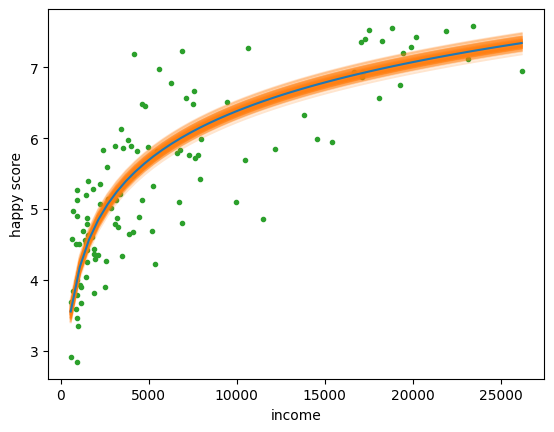

In [ ]:
#Posterior predictive graph

#grabs 100 posterior samples
posterior = az.extract(idata_v3, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(data.income.min(), data.income.max(), 50),
    dims="plot_id"
    )


mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

#These are a 50 lines that our model came up with
lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, np.log(lines.T), c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, np.log(mean_line), c="C0", label="mean line")

#plot the raw data
ax.plot(data.income, data.happy_score, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("income")
ax.set_ylabel("happy score")

Output()

(0.0, 10.0)

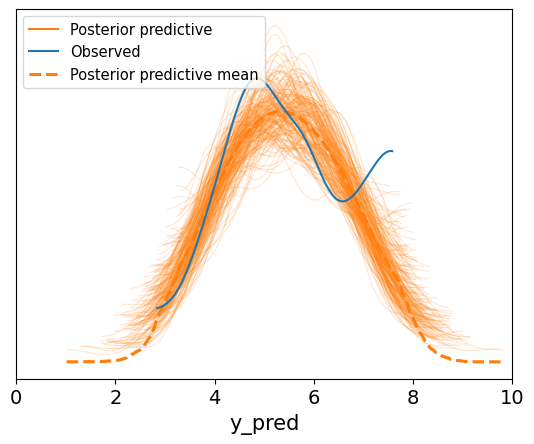

In [ ]:
# posterior predictive check

pm.sample_posterior_predictive(
    idata_v3, model = model_v3, extend_inferencedata=True
    )
ax = az.plot_ppc(idata_v3, num_pp_samples=200, colors=["C1", "C0", "C1"])
plt.xlim(0,10)

This was probably the best thing that has ever happended to this model. The PPC is loking SO much better. The graph is looking pretty good. However, there is still one thing that is bothering me. The mean line of my graph is an almost perfect fit, but the standard deviation is way to small. All of my posterior predictive lines are hardly representitive of my range of points.

**Version 4**

This is a huge change. Not only am I switiching model types and likelihoods (thanks Mr. Arredondo!), but I am also altering my priors and addding a new one for a new parameter. Lets break it down:

- This new model will allow me to expand my stadard deviation and control how it varies for different values of x
    - This is important for me because if you look at my data, the standard deviation from the mean line sort of decreases, increases, then decreases again. Sort of like a quadratic function... For this reason I am squaring my standard deviation line.

- I am also switching to a StudentT likelihood, this likelihood will better fit the shape of my data

- I am also adding a new prior for my new paramemter. Since nu is a required paramenter for StudentT, I created a new prior for it (v). This prior is an exponential prior because the number of outliers increases as x increases (standard deviation increases)

- I am also making some minor changes to the values of my other priors. Nothing major, just making them make a little more sense for the new and improved model.

In [ ]:
with pm.Model() as model_v4:

    #priors for line for our mean
    α = pm.Normal("α", sigma=5)  #y-int
    β = pm.Normal("β", sigma=20)  #slope

    #priors for the standard deviation line
    γ = pm.HalfNormal("γ", sigma=50)
    δ = pm.HalfNormal("δ", sigma=50)

    #prior for nu
    v = pm.Exponential("v", lam=1/30)

    #mean line
    μ = pm.Deterministic("μ", np.log(α + β * data.income))

    #standard deviation line; this allows it to vary over the x values
    σ = pm.Deterministic("σ", np.square(γ + δ * data.income))

    #StudentT likelihood
    y_pred = pm.StudentT("y_pred", mu=μ, sigma=σ, nu=v, observed=data.happy_score)

    idata_v4 = pm.sample()

Output()

Output()

Output()

<Axes: xlabel='y_pred'>

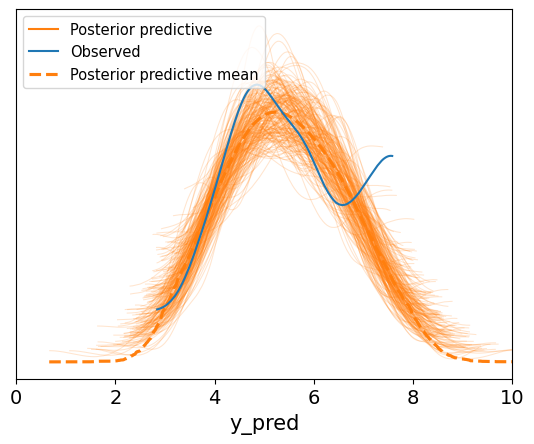

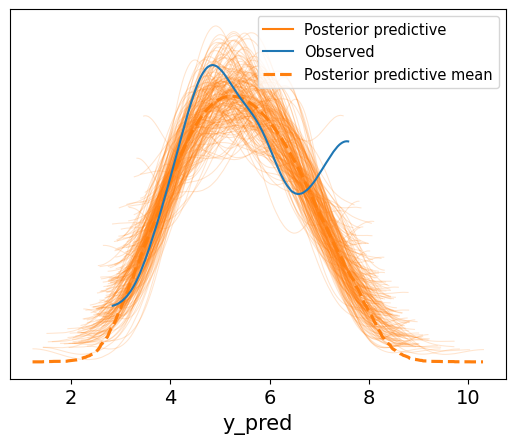

In [ ]:
# posterioir predictive check

pm.sample_posterior_predictive(
    idata_v4, model = model_v4, extend_inferencedata=True
    )
ax = az.plot_ppc(idata_v4, num_pp_samples=200, colors=["C1", "C0", "C1"])
plt.xlim(0,10)
az.plot_ppc(idata_v4, num_pp_samples=200, colors=["C1", "C0", "C1"])

Text(0.5, 0, 'income')

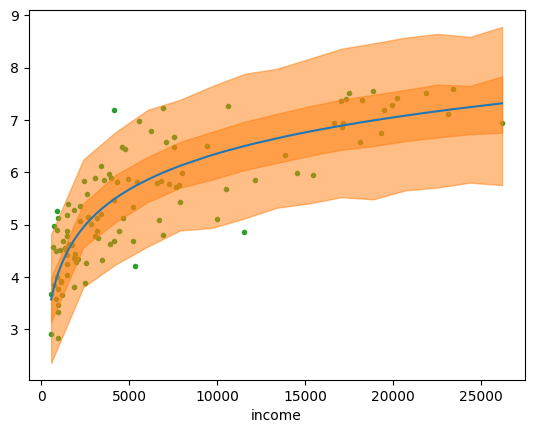

In [ ]:
# posterioir predictive graph

mean_line = idata_v4.posterior["μ"].mean(("chain", "draw"))
incomes = np.random.normal(data.income.values, 0.01)
idx = np.argsort(incomes)
x = np.linspace(incomes.min(), incomes.max(), 15)
y_pred_q = idata_v4.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(incomes[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

_, ax = plt.subplots()
ax.plot(data.income, data.happy_score, "C2.", zorder=-3)
ax.plot(data.income[idx], mean_line[idx], c="C0")

for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

ax.set_xlabel("income")

That graph is like a work of art... but something looks a little off. The standard deviation looks really good, but instead of decreasing, increasing, then decreasing again, it's only decreasing then increasing. however, the PPC is looking good, and I am pretty happy with this overall.

**Version 5**

While version 4 is looking really good, there is still room for improvement. In this version I will try to add that second decrease to my standard deviation. This is how I am going to go about it:

- I feel like the best way to try and do this is mess with my standard deviation line... Let's try logging and squarerooting my data (Just to see what happes :P)

Keep in mind that I am not actually sure if thiis is the best course of action. At this point I am just playing around and trying to see what works.

In [ ]:
with pm.Model() as model_v5:

    #priors for line for our mean
    α = pm.Normal("α", sigma=5)
    β = pm.Normal("β", sigma=20)

    #priors for standard deviation line
    γ = pm.HalfNormal("γ", sigma=50)
    δ = pm.HalfNormal("δ", sigma=50)

    #Prior for nu
    v = pm.Exponential("v", lam=1/30)

    #mean line
    μ = pm.Deterministic("μ", np.log(α + β * data.income))

    #standard deviation line; this allows it to vary over the x values
    σ = pm.Deterministic("σ", np.square(γ + δ * np.sqrt(np.log(data.income)))) #log and then square root on the data

    #StudentT likelihood
    y_pred = pm.StudentT("y_pred", mu=μ, sigma=σ, nu=v, observed=data.happy_score)

    idata_v5 = pm.sample()

Output()

Output()

ERROR:pymc.stats.convergence:There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

<Axes: xlabel='y_pred'>

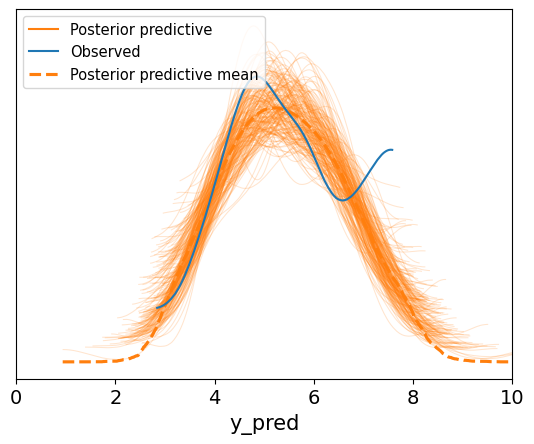

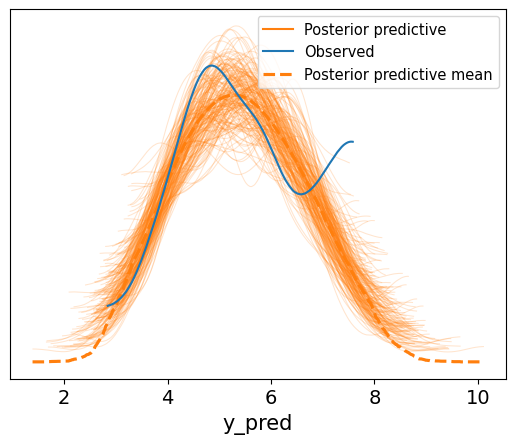

In [ ]:
# posterior predictive check

pm.sample_posterior_predictive(
    idata_v5, model = model_v5, extend_inferencedata=True
    )
ax = az.plot_ppc(idata_v5, num_pp_samples=200, colors=["C1", "C0", "C1"])
plt.xlim(0,10)
az.plot_ppc(idata_v5, num_pp_samples=200, colors=["C1", "C0", "C1"])

Text(0.5, 0, 'income')

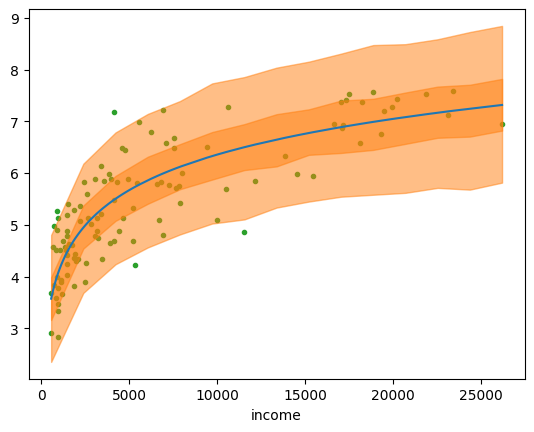

In [ ]:
# posterior predictive graph

mean_line = idata_v5.posterior["μ"].mean(("chain", "draw"))
incomes = np.random.normal(data.income.values, 0.01)
idx = np.argsort(incomes)
x = np.linspace(incomes.min(), incomes.max(), 15)
y_pred_q = idata_v5.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(incomes[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

_, ax = plt.subplots()
ax.plot(data.income, data.happy_score, "C2.", zorder=-3)
ax.plot(data.income[idx], mean_line[idx], c="C0")

for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

ax.set_xlabel("income")

That was really anti-climactic. Both PPCs loook almost exactly the same. Except for the 31 divergences of couse. Im not really sure what's up with those....

**Conclusion**

I have run out of time, so no more versions. But that's ok, I think I made some really good progress. Overall I think versions 4 and 5 were the best ones. They both looked pretty similar. It was defenitley the varying standard deviation that helped a lot, plus the logging of the mean line.

**References**

data-

https://www.kaggle.com/datasets/levyedgar44/income-and-happiness-correction
